<a href="https://colab.research.google.com/github/Nikhileswar-Komati/Deep-Learning/blob/master/VIOLENCE_vgg_95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "nikhileswarkomati"
os.environ['KAGGLE_KEY'] ="e75f0f971ce7ce2b2bc748fa02cbafd1"
!kaggle datasets download -d mohamedmustafa/real-life-violence-situations-dataset -p /content

100% 3.58G/3.58G [01:11<00:00, 75.2MB/s]
100% 3.58G/3.58G [01:12<00:00, 53.3MB/s]


In [ ]:
!unzip \*.zip

In [ ]:
!pip install keras-video-generators

In [4]:
import keras
from keras_video import VideoFrameGenerator
# use sub directories names as classes
classes = ['Violence', 'NonViolence']
classes.sort()
# some global params
SIZE = (150,150)
CHANNELS = 3
NBFRAME = 6
BS = 8
# pattern to get videos and classes
glob_pattern = '/content/Real Life Violence Dataset/{classname}/*'
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    rotation_range=8,
    width_shift_range=.1,
    height_shift_range=.1)
# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split_val=.10, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

Using TensorFlow backend.


class NonViolence, validation count: 100, train count: 900
class Violence, validation count: 100, train count: 900
Total data: 2 classes for 1800 files for train


In [5]:
valid = train.get_validation_generator()

Total data: 2 classes for 200 files for validation


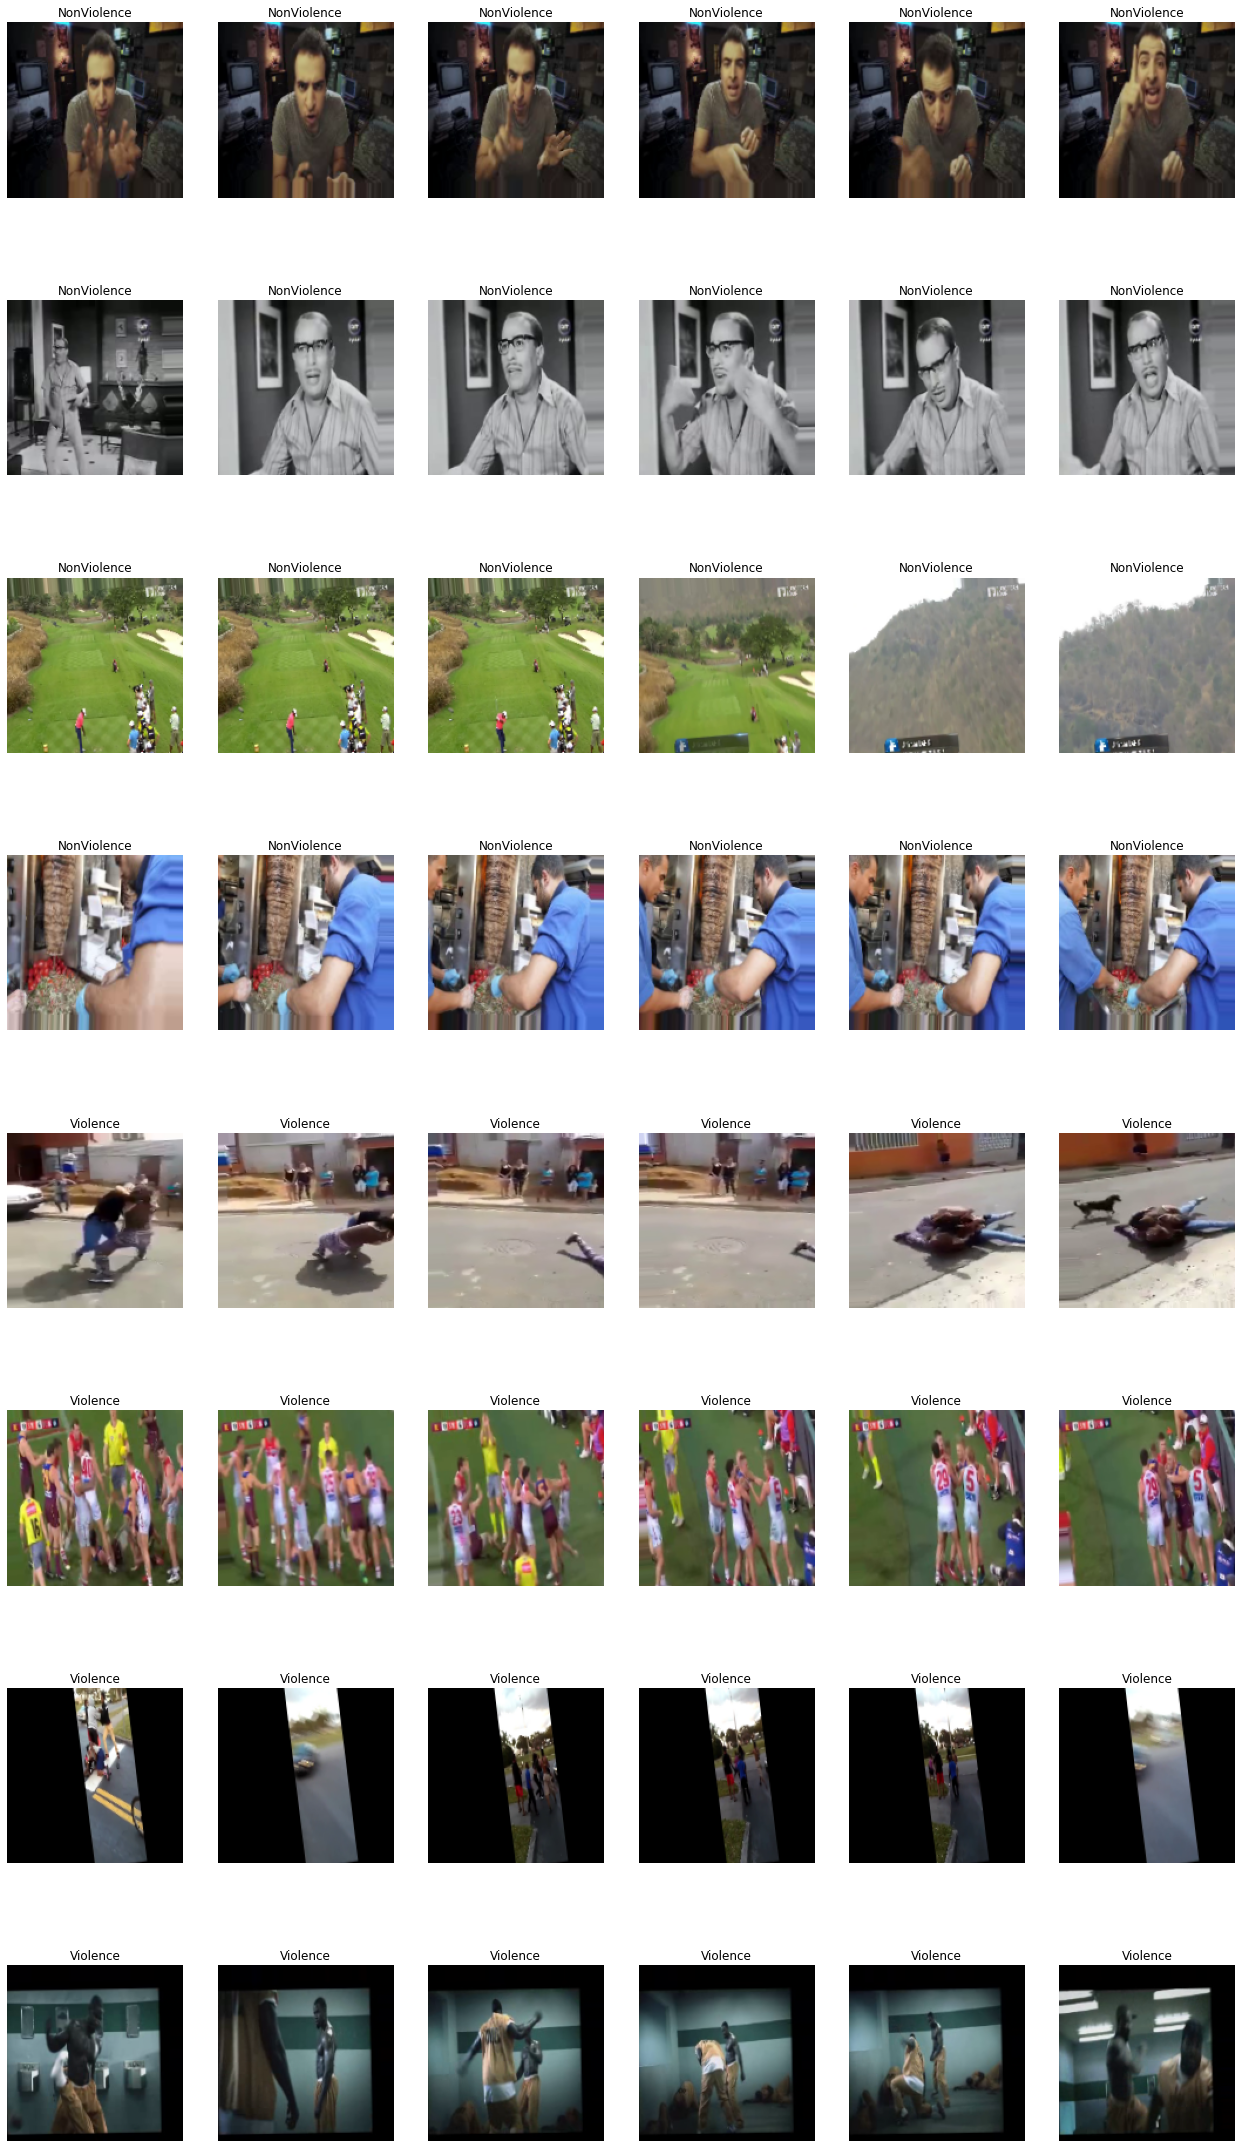

In [6]:
import keras_video.utils
keras_video.utils.show_sample(train)

In [7]:
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from keras.layers import TimeDistributed, GRU, Dense, Dropout
import keras

In [8]:
def build_vgg(shape=(150, 150, 3), nbout=2):
    model = keras.applications.VGG19(
        include_top=False,
        input_shape=shape,
        weights='imagenet')
    # Keep 9 layers to train﻿﻿
    trainable = 9
    for layer in model.layers[:-trainable]:
        layer.trainable = False
    for layer in model.layers[-trainable:]:
        layer.trainable = True
    output = GlobalMaxPool2D()
    return keras.Sequential([model, output])

In [9]:
def action_model(shape=(6, 150, 150, 3), nbout=2):
    convnet = build_vgg(shape[1:], nbout = 2)
    
    # then create our final model
    model = keras.Sequential()
    model.add(TimeDistributed(convnet, input_shape = shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model
    # ...

In [10]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,)
model = action_model(INSHAPE, len(classes))
optimizer = keras.optimizers.SGD()
model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['acc']
)

80142336/80134624 [==============================] - 3s 0us/step


In [11]:
!mkdir chkp
EPOCHS=20
# create a "chkp" directory before to run that
# because ModelCheckpoint will write models inside
callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
        'chkp/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1),
]
history = model.fit_generator(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/20
183/225 [=======================>......] - ETA: 1:51 - loss: 0.6966 - acc: 0.5362

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 11 could not be retrieved. It could be because a worker has died.
  UserWarning)


225/225 [==============================] - 702s 3s/step - loss: 0.6875 - acc: 0.5511 - val_loss: 0.6727 - val_acc: 0.6700

Epoch 00001: saving model to chkp/weights.01-0.67.hdf5
Epoch 2/20
225/225 [==============================] - 101s 449ms/step - loss: 0.6114 - acc: 0.6750 - val_loss: 0.4207 - val_acc: 0.7600

Epoch 00002: saving model to chkp/weights.02-0.42.hdf5
Epoch 3/20
225/225 [==============================] - 101s 448ms/step - loss: 0.4641 - acc: 0.7956 - val_loss: 0.0665 - val_acc: 0.7950

Epoch 00003: saving model to chkp/weights.03-0.07.hdf5
Epoch 4/20
225/225 [==============================] - 101s 449ms/step - loss: 0.6363 - acc: 0.6144 - val_loss: 0.5512 - val_acc: 0.6700

Epoch 00004: saving model to chkp/weights.04-0.55.hdf5
Epoch 5/20
225/225 [==============================] - 101s 448ms/step - loss: 0.5043 - acc: 0.7689 - val_loss: 0.1945 - val_acc: 0.8850

Epoch 00005: saving model to chkp/weights.05-0.19.hdf5
Epoch 6/20
225/225 [==============================] - 

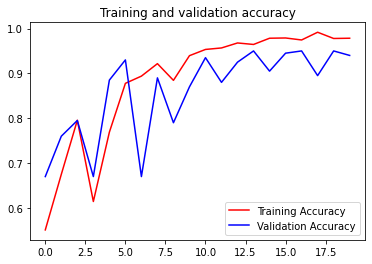

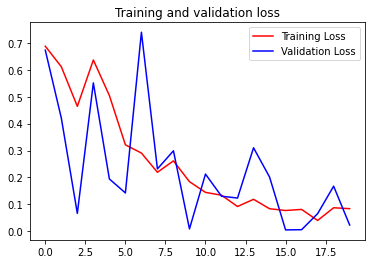

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")


plt.title('Training and validation loss')
plt.legend()
plt.show()